# Changelog:
- v3.0: loss menggunakan binary_crossentropy
- v3.1: print confusion matrix using sklearn
- v4.0: pake augmentation + transfer learning procedure

In [50]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import ConfusionMatrixDisplay

# Load Images

In [51]:
# Setup for image loader
batch_size = 32
img_height = 255
img_width = 255

# Train dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory="dataset_ori",
    validation_split=0.2,
    subset="training",
    seed=123, 
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 6400 files belonging to 2 classes.
Using 5120 files for training.


In [52]:
# Validation dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory="dataset_ori",
    validation_split=0.2,
    subset="validation",
    seed=123, 
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 6400 files belonging to 2 classes.
Using 1280 files for validation.


In [53]:
# Test dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [54]:
# Check for image labels
class_names = train_ds.class_names
print(class_names)

['neutral', 'porn']


Check for images preview. **NSFW WARNING!!**

In [55]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(12):
#     ax = plt.subplot(3, 4, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

# Define Model

In [56]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [59]:
IMG_SHAPE = (img_height, img_width)+(3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6168\2931805324.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


In [60]:
base_model.trainable = False

In [61]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 255, 255,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_13[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [62]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

In [63]:
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [64]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [65]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [66]:
inputs = tf.keras.Input(shape=(255, 255, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [67]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Compile and Train

In [68]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 724ms/step - accuracy: 0.4575 - loss: 0.8335


In [70]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.44


In [71]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 165s 996ms/step - accuracy: 0.6346 - loss: 0.6543 - val_accuracy: 0.8604 - val_loss: 0.3562
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 151s 946ms/step - accuracy: 0.8510 - loss: 0.3500 - val_accuracy: 0.9141 - val_loss: 0.2344
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 152s 949ms/step - accuracy: 0.8956 - loss: 0.2639 - val_accuracy: 0.9365 - val_loss: 0.1841
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 150s 940ms/step - accuracy: 0.9084 - loss: 0.2294 - val_accuracy: 0.9443 - val_loss: 0.1594
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 155s 969ms/step - accuracy: 0.9197 - loss: 0.2060 - val_accuracy: 0.9551 - val_loss: 0.1468
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9332 - loss: 0.1853 - val_accuracy: 0.9590 - val_loss: 0.1370
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9284 - loss: 0.1804 - val_accuracy: 0.9619 - val_loss: 0.1256
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 155s 968ms/step - accuracy: 0.9359 - loss:

In [72]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 739ms/step - accuracy: 0.9853 - loss: 0.0872
Test accuracy : 0.98046875


In [78]:
# model.save('model_v4.0.h5')

# Model Evaluation

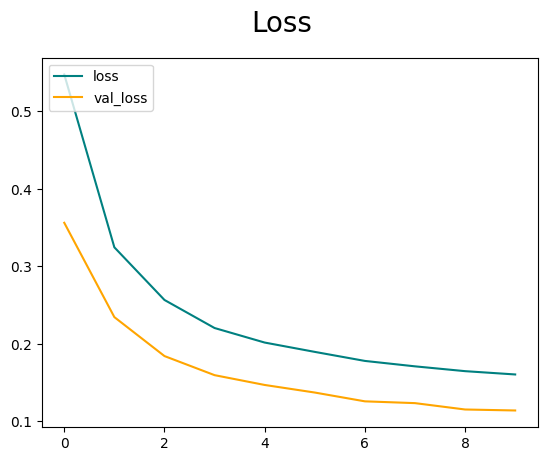

In [93]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 10
epochs_range = range(epochs)

fig = plt.figure()
plt.plot(epochs_range, loss, color='teal', label='loss')
plt.plot(epochs_range, val_loss, color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

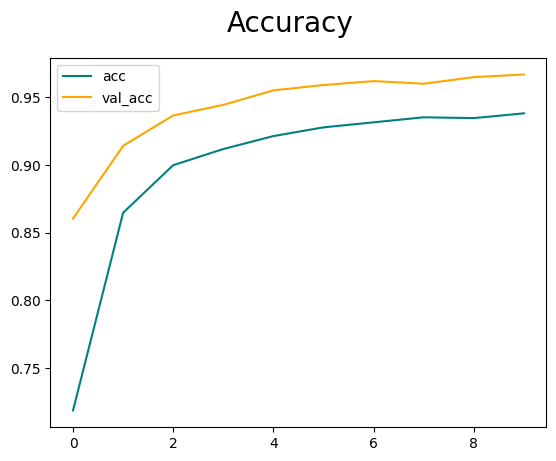

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

fig = plt.figure()
plt.plot(epochs_range, acc, color='teal', label='acc')
plt.plot(epochs_range, val_acc, color='orange', label='val_acc')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [79]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)
y_test = list(map(lambda x: class_names[x],y_test))

In [80]:
y_prob = model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 690ms/step


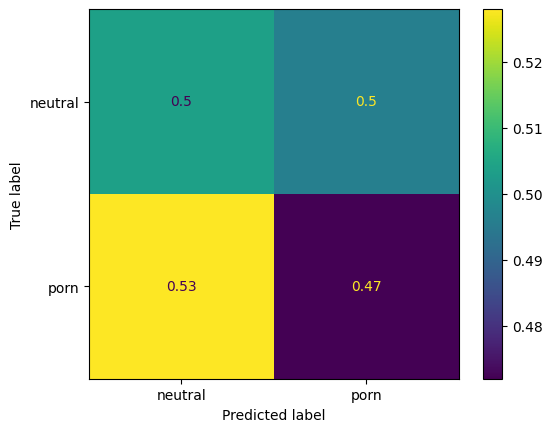

In [81]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

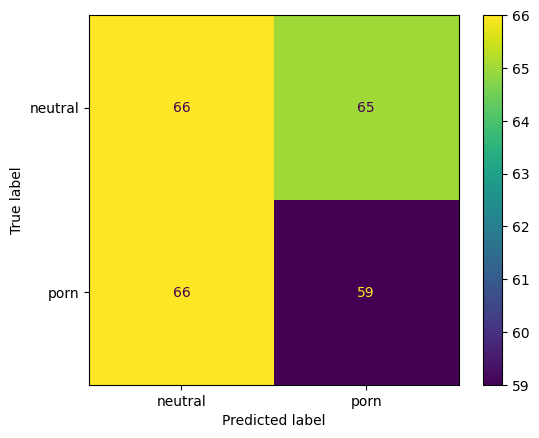

In [82]:

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

# Fine Tuning

In [83]:
base_model.trainable = True

In [86]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [87]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [88]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 255, 255, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 1,864,002 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [89]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.7788 - loss: 0.5669 - val_accuracy: 0.9023 - val_loss: 0.2696
Epoch 11/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9384 - loss: 0.1663 - val_accuracy: 0.9473 - val_loss: 0.1466
Epoch 12/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9384 - loss: 0.1565 - val_accuracy: 0.9639 - val_loss: 0.1026
Epoch 13/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.9483 - loss: 0.1395 - val_accuracy: 0.9727 - val_loss: 0.0737
Epoch 14/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9594 - loss: 0.1097 - val_accuracy: 0.9727 - val_loss: 0.0711
Epoch 15/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9591 - loss: 0.1088 - val_accuracy: 0.9736 - val_loss: 0.0680
Epoch 16/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.9692 - loss: 0.0978 - val_accuracy: 0.9746 - val_loss: 0.0652
Epoch 17/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.9638 - loss: 0.0981 - 

In [97]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

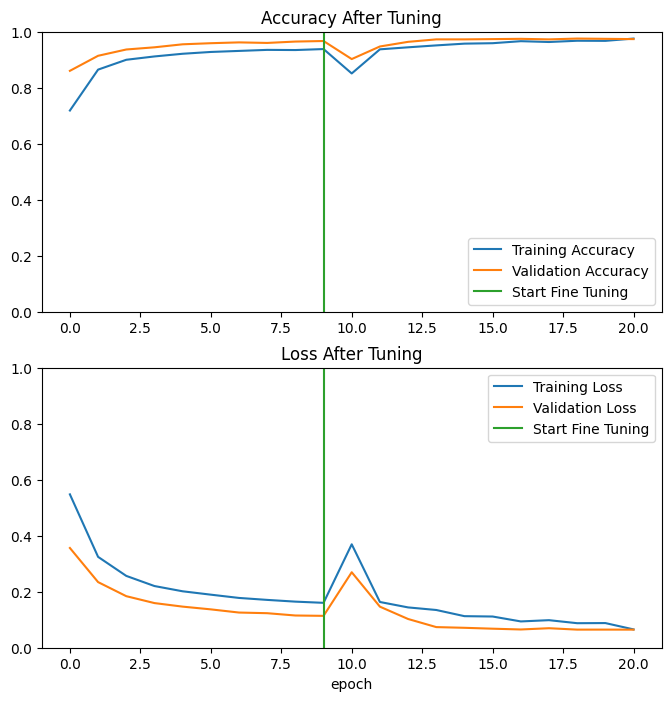

In [99]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy After Tuning')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Loss After Tuning')
plt.xlabel('epoch')
plt.show()

In [100]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 703ms/step - accuracy: 0.9866 - loss: 0.0297
Test accuracy : 0.984375


In [101]:
y_prob= model.predict(test_ds)
y_pred = y_prob.argmax(axis=1)
y_pred = list(map(lambda x: class_names[x],y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 667ms/step


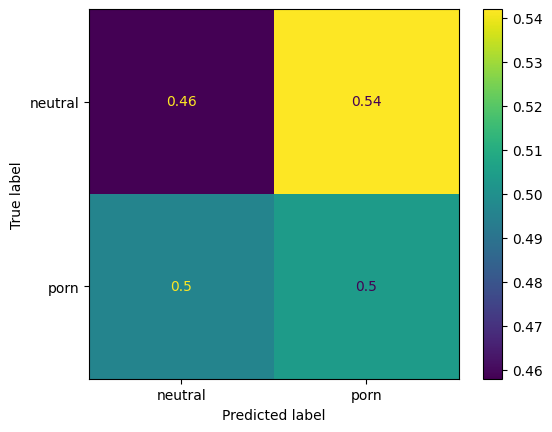

In [102]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred, normalize = 'true')

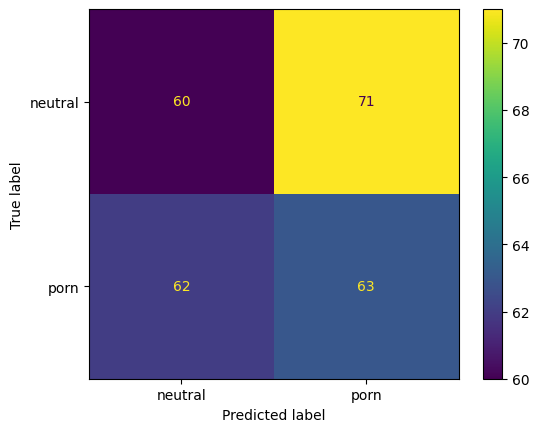

In [103]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [104]:
model.save('model_vfinal.keras')